# An Analysis of Four Different Formulations of Chalk on Grip Strength

Ethan Basingr and Jerry H. Yu

## Introduction

Climbing Chalk is commonly used to enhance grip strength in sports like rock climbing or powelifting. Most commercial brands of climbing chalk are made with Magnesium Carbonate (MgCO3). However, Magnesium carbonate has a wide variety of crystal structures that can affect its ability to absorb water and other fluids. My friend Ethan spent month designing a new way to crystallize MgCO3 to hopefull make suprior chalk to commercial brands. This report analyzes an experiment he conducted with a third friend analyze and chalk to other brands. 

## Methods

The experiment was conducted as an unbalanced block design. Testing constraints prevented the easy swapping between chalks during a single test, so chalks were testred sequentially across days, resulting in confounding. While such bias is impossible to correct completley for the final analysis, I did try two approaches to correct it. I decided to use mixed models to evaluate the data. 

In [ ]:
# Set Up Python Enviroment
import math
import numpy as np
import pandas as pd
import plotly.express as px
import os
import git
import rpy2
%load_ext rpy2.ipython
import statsmodels
import statsmodels.formula.api as smf
import plotly.io as pio
repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)
print(os.getcwd())

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


c:\Users\Public\Documents\Personal_Projects\Ethan_Chalk_Project


In [2]:
%%R
# Set Up R Enviroment in Python
library(tidyverse)
library(lmtest)
library(here)
library(lme4) 
library(MASS)
library(MuMIn)
library(caret)
library(clubSandwich)
library(emmeans)
library(pbkrtest)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: 'zoo'


R[write to console]: The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


R[write to console]: here() starts at C:/Users/Public/Documents/Personal_Projects/Ethan_Chalk_Project

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: 'Matrix'


R[write to console]: The following objects are masked from 'package:tidyr':

    expand, pack, unpack


R[write to console]: 
Attaching package: 'MASS'


R[write to console]: The following object is masked from 'package:dplyr':

    select


R[write to console]: Loading required package: lattice

R[write to console]: 
Attaching package: 'caret'


R[write to console]: The following object is masked from 'package:purrr':

    lift


R[write to console]: Registered S3 method overwritten by 'clubSandwich':
  method    from    
  bread.mlm sandwich

R[write to console]: Welcome to

# Data

The original data was not formatted in the way of a long table, so I used excel to clean the data. Multiple explanatory variables were encoded in color or order of the tables, so they needed to be made explicit. I used a series of formulas for that. Thus, I created long formats of the `Chalk_Results.xlsx` and `Randomized tests.xlsx` (`Chalk_Long.xlsm` and `Metadata.slsx`) and merged and created labels for them in python. 

Variables are:
- **Code:** a number from 1-24. In excel, this column's color is indicative of date, and its value is also indicative of control (or chalk) and treatment. Code + bChalk form the key for merging metadata with chalk_long. 
- **bChalk:** a number from 1-4 (1=FL. 2=Metolius, 3=Magdust, 4=Ethan's Chalk), not directly indicative of whether chalk was used. Code + bChalk form the key for merging metadata with chalk_long.
- **Pinch_Order:** Order in which test was conducted, for each attempt (code number), the test was performed three times sequentially. Pinch_Order + bChalk + Code forms the primary key. 
- **Pinch:** The weight at which the board was pinched. 
- **Pull:** The weight just before the hand slipped. **Our dependent variable**. 
- **Chalk:** The actual chalk used, 0 is added for control. 
- **Used:** A Dummy variable for is chalk is used or not. Used in testing the random effects. 
- **Person:** The person conducting the test, one intermediate and one advanced climber. 
- **Day:** The day when the test was conducted. Dates were, 10/30/2024,10/31/2024,11/4/2024,11/6/2024,11/8/2024,11/10/2024, and 11/14/2024. Last two were apparently "noticeably slippery". 
- **Day_Order:** The order in which the tests were conducted in the day. This was randomized. 

# Wrangling

The wrangling section is below. Mostly easy to clean, but some variables needed to be converted into factors. 

In [3]:
# Read in and Merge Data and Metadata
Chalk_Long = pd.read_excel('data/Raw/Chalk_Long.xlsm', sheet_name=1, header=0)
metadata = pd.read_excel('data/Raw/Metadata.xlsx', sheet_name=1, header=0)
Chalk = pd.merge(metadata, Chalk_Long, on=["Code","bChalk"], how='left')
#Chalk.to_csv('data/Processed/Chalk.csv', index=False)
# Convert Labels into factor variables for further analysis
Chalk["Chalk"] = Chalk["Chalk"].astype("category")
Chalk["Chalk"] = Chalk["Chalk"].cat.rename_categories(["None", "FL", "Metolius", "Magdust", "Ethan"])
Chalk["Pinch_Order"] = Chalk["Pinch_Order"].rank(method='dense')
Chalk["Day_Chalk"] = Chalk["Day"].astype("str") + "_" + Chalk["Chalk"].astype("str")
Chalk["Used"] = [0 if c== "None" else 1 for c in Chalk["Chalk"]]
Chalk["Used"] = Chalk["Used"].astype("category")
Chalk["Used"] = Chalk["Used"].cat.rename_categories(["None", "Chalk"])
Chalk["Person"] = Chalk["Person"].astype("category")
Chalk["Day"] = Chalk["Day"].astype("category")

In [4]:
# Now let us check that our wrangling worked as expected
%R -i Chalk
Chalk.info()
Chalk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Code         576 non-null    int64   
 1   bChalk       576 non-null    int64   
 2   Day_Order    576 non-null    int64   
 3   Day          576 non-null    category
 4   Pinch        576 non-null    float64 
 5   Pull         576 non-null    float64 
 6   Pinch_Order  576 non-null    float64 
 7   Chalk        576 non-null    category
 8   Person       576 non-null    category
 9   Day_Chalk    576 non-null    object  
 10  Used         576 non-null    category
dtypes: category(4), float64(3), int64(3), object(1)
memory usage: 34.7+ KB


c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning:

Error while trying to convert the column "Day". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning:

Error while trying to convert the column "Person". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.



,Code,bChalk,Day_Order,Day,Pinch,Pull,Pinch_Order,Chalk,Person,Day_Chalk,Used
0,16,1,1,2024-10-30,4.202,34.6,1.0,None,1,2024-10-30_None,None
1,16,1,1,2024-10-30,4.117,31.9,2.0,None,1,2024-10-30_None,None
2,16,1,1,2024-10-30,4.154,31.9,3.0,None,1,2024-10-30_None,None
3,34,1,2,2024-10-30,4.088,41.1,1.0,FL,2,2024-10-30_FL,Chalk
4,34,1,2,2024-10-30,4.088,44.5,2.0,FL,2,2024-10-30_FL,Chalk


# EDA

Next Graphs to Visualize Key Variables

- First I will check the distributions of the numeric variables. 

In [5]:
# Graph Pinch
pinchist = px.histogram(Chalk,x="Pinch",
                        title = "Distribution of Pinch Strength",
                        nbins = 20)
pinchist.update_layout(
    title = {
        "text":"Distribution of Pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
pinchist.show()
# weird shape, good coverage, no noticable outliers

Notes:
- at lower weights, obviously had more control so more centered around 1 lb, 2lb etc. However the distirbution is pretty uniform

In [6]:
# Graph Pull
pullhist = px.histogram(Chalk,x="Pull",
                        title = "Distribution of Pull Strength")
pullhist.update_layout(
    title = {
        "text":"Distribution of Pull Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
pullhist.show()
#right tail, might need normalization

- Very significant right skew. This is a sign of nonnormality. 

In [7]:
# Now Graph Relation Between Pinch and Pull
pinchpull = px.scatter(Chalk, x = "Pinch", y = "Pull",title = "Kilograms Pulled by pinch Strength")
pinchpull.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
pinchpull.show()

#nice and Linear, but maybe not homoscedastic

- This shows a mostly linear relationship by very homoscedastic data. 

Now we will split this relationship by some of the categorical variables to evaluate impact. 

In [8]:
# Type of Chalk
byChalk = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Chalk", title = "Kilograms Pulled by pinch Strength")
byChalk.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byChalk.show()

# Very Nice Separation for Control and using Chalk, between chalks is less clear. 

byDate = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Day", title = "Kilograms Pulled by pinch Strength")
byDate.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byDate.show()
# There are not that clear of patterns (seperation) in date. 

- The patterns found in chalk are a good sign, likewise the lack of a clear pattern in date. 

In [9]:
# Person
byPerson = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Person", title = "Kilograms Pulled by pinch Strength")
byPerson.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byPerson.show()

# Clear Difference by person, as expected

In [10]:
# Test Pinch Order
byOrder = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Pinch_Order", title = "Kilograms Pulled by pinch Order")
byOrder.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Order<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byOrder.show()

# Very random, quite nice

# Test Day Order
byDay = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Day_Order", title = "Kilograms Pulled by Day_Order")
byDay.update_layout(
    title = {
        "text":"Kilograms Pulled by Day_Order<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byDay.show()
%R -i Chalk

# Generally Also Pretty Random

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning:

Error while trying to convert the column "Day". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning:

Error while trying to convert the column "Person". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.



### Graph Summary
- From our EDA we have generally shown that there appears to be good separation from chalk and person, and negligible for day order and pinch order.
- However, we cannot avoid confonding of chalk and day. 
- The data is also somewhat group unbalanced, with control being overrepresented. Linearity looks fine, but not homoscedasticity or normality.

Now we will test assumptions needed for Linear Mixed Models. I will increase power using chalk instead of bChalk initially for testing. So instead of each individual chalk, we are testing whether using chalk at all is significant. This results in control and treatment groups of roughly equal size and removes confounding from type of chalk by ignoring it. 

In [11]:
%%R -o resid -o predict
Chalk$Day = as.factor(Chalk$Day)
Chalk$Person = as.factor(Chalk$Person)
# Now we will test assumptions needed for Linear Mixed Models and the random effects structure
# First Fit a Full Model of All Relevant Variables and a model without Date to Test Significance of Date
twoeffects = lmer(Pull~Pinch*Used + (1|Person) + (1 | Person:Day),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail) 
nested = lmer(Pull~Pinch*Used + (1 | Person:Day),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail) 
indep = lmer(Pull~Pinch*Used + (1 | Day) + (1|Person),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail) 
nodate = lmer(Pull~Pinch*Used + (1|Person), 
            data = Chalk)
print(AIC(twoeffects, nested, indep, nodate))
print(BIC(twoeffects, nested, indep, nodate))

# Very Very Siginificant Effect on Fit, nested random better than crossed random
resid = summary(nested)$residuals
predict = predict(nested)

# Test Practical Significance with Effect Size/Fit
print("Random Intercepts for Person and For Each Person by Day Group")
r.squaredGLMM(twoeffects) |> print()
print("Random Intercept for Person by Day Group")
r.squaredGLMM(nested) |> print()
print("Random Intercept for Person and Day")
r.squaredGLMM(indep) |> print()
print("Random Intercept for Person Only")
r.squaredGLMM(nodate) |> print()

           df      AIC
twoeffects  7 3556.291
nested      6 3555.706
indep       7 3576.381
nodate      6 3657.689
           df      BIC
twoeffects  7 3586.784
nested      6 3581.843
indep       7 3606.874
nodate      6 3683.826
[1] "Random Intercepts for Person and For Each Person by Day Group"
           R2m       R2c
[1,] 0.8914495 0.9276219
[1] "Random Intercept for Person by Day Group"
           R2m       R2c
[1,] 0.8911071 0.9276359
[1] "Random Intercept for Person and Day"
           R2m       R2c
[1,] 0.8876317 0.9241147
[1] "Random Intercept for Person Only"
           R2m       R2c
[1,] 0.8761392 0.9104231


- From AIC and BIC (Basically comparing how likley our data would be assuming that our model was correct while accounting for increasing number of variables) we see that the model that includes the only nested Person Date conponent is the best model. 
- However we see from the conditional coefficient of determination (basically an approximation of how much of the variability of the data can be explained by our model) that the effects are very small, indicating that Date probably does not have  much of an effect on explaining the variation in our data. This is good because it might indicate that confounding does not have much of an effect. 

In [12]:
# Test Residuals
testrelresid = px.scatter(x = predict,
                          y = resid,
                          title = "Residuals",
                          labels = {"x": "Predicted Values", "y": "Residuals"})
testrelresid.show()
# Very Heteroscedastic

- Very heteroscedastic. Now Test Normality


	Shapiro-Wilk normality test

data:  residuals(nested)
W = 0.98422, p-value = 6.904e-06



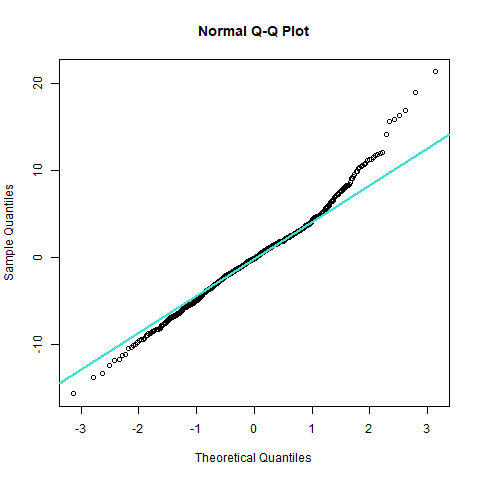

In [13]:
%%R
qqnorm(residuals(nested))
qqline(residuals(nested),col="turquoise",lwd=2)
# Towards the Top seems nonormal
shapiro.test(residuals(nested))
# Also Nonnormal

- Also not very normal. 

# Data Analysis Plan

### Summary
- Use linear mixed models to model the effect of chalk and pinch strength on pull strength, with Person and Date as random effects. Day Order and Pinch Order were not used for this model because Day Order was randomized and Pinch Order was not very significant in the EDA. 
- Perform pairwise contrasts between types of chalk or combinations of Chalk and day. 

### Addressing Data Abnormalities
- For model selection, I used bootstrapped Likleyhood Ratio Tests. Basically, I compared how likley the data was with a larger model and a smaller model with one or more explnatory variables removed. Instead of assuming a specific distirbution, which would require our assumptions be met, I resampled out data repeatedly and used the values of my subsamples to get a distribution. This reduced the impact of heteroscedasticity and nonnormality for model selection. 
- To address nonnormality, I tried a variety of different transforms. The one that worked the best was a log transform of the independent variable (Pinch). This did not entirely correct nonormality, but the sample size was large enough that felt that the CLT would apply.
- To address heteroscedasticity, I used robust sandwhich estimators for means comparison. 
- I tried two approaches to address confounding. 

1. Incorporate: Fit on the model with the interaction of Date and Chalk Type. This Removes the Confounding, but makes interpreting the final results very difficult. Additionally, since the number of observations for certain groups is small (9 observations per subgroup), the ability to make statistically significant inferences is impaired. 

1. Ignore: Fit model with the same random effects structure from above. While This does not address confounding, we saw from the conditional coefficient of detemrination the effect of Date on overall model fit was negligible, so I felt confident in that.  


## Approach Number One: Analyze Confounding by Using Date-Chalk Combinations

In [14]:
%%R
# Fit a full model with the Confounded Chalk and Day Variables
# All interaction Terms
fullnest = lmer(Pull~log(Pinch) + Day_Chalk + log(Pinch):Day_Chalk + (1 | Person),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail)
# No Interaction Terms
partial = lmer(Pull~log(Pinch) + Day_Chalk + (1 | Person),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail)
# No Day*Chalk Variable
partial1 = lmer(Pull~log(Pinch) + (1 | Person),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail)

# Test Statistical Significance with Boostrapped Model Comparison
boot1 = PBmodcomp(
  fullnest,
  partial,
  nsim = 1000,
  seed=42
)
boot2 = PBmodcomp(
  partial,
  partial1,
  nsim = 1000,
  seed=42
)

boot1 |> print()
boot2|> print()

# Test Practical Significance with Effect Size/Fit
r.squaredGLMM(fullnest) |> print()
r.squaredGLMM(partial) |> print()
r.squaredGLMM(partial1) |> print()


Bootstrap test; time: 12.43 sec; samples: 1000; extremes: 0;
large : Pull ~ log(Pinch) + Day_Chalk + log(Pinch):Day_Chalk + (1 | Person)
Pull ~ log(Pinch) + Day_Chalk + (1 | Person)
         stat df   p.value    
LRT    146.58 16 < 2.2e-16 ***
PBtest 146.58     0.000999 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Bootstrap test; time: 10.11 sec; samples: 1000; extremes: 0;
large : Pull ~ log(Pinch) + Day_Chalk + (1 | Person)
Pull ~ log(Pinch) + (1 | Person)
         stat df   p.value    
LRT    376.16 16 < 2.2e-16 ***
PBtest 376.16     0.000999 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
           R2m      R2c
[1,] 0.8899425 0.906717
          R2m       R2c
[1,] 0.864733 0.8792501
           R2m       R2c
[1,] 0.7531656 0.7674678


- For our boostrapped LRTs, the interaction of Day_Chalk and Pinch as well as the Day_Chalk variable are significant. 
- However, we see that for the marginal coefficient of determination (the amount of variability in our model explained by our fixed effects only) between the model with the interaction term and the model without is very small. That means the practical difference in how well the model explains the data for the model with the interaction between Pinch and Day_Chalk is negligible. 

Thus for ease of interpretaion of an already harder to interpret model, I will use the model without the interaction term. 

In [15]:
%%R -o emmplot -o contrasts
finalmodel = lmer(Pull~log(Pinch) + Day_Chalk + (1 | Person),
                data = Chalk,
                REML = TRUE,
                na.action=na.fail)
# Now we do Mean Comparisons
corCov = vcovCR(finalmodel,type="CR2")
robustemm = emmeans(finalmodel, specs = ~Day_Chalk, vcov = corCov, type = "response")
contrasts = summary(pairs(robustemm))
emmplot = summary(robustemm, infer = TRUE)
Chalk |> group_by(Day_Chalk) |> summarise(n()) |> print()

R[write to console]: Kenward-Roger method can't be used with user-supplied covariances



# A tibble: 17 x 2
   Day_Chalk           `n()`
   <chr>               <int>
 1 2024-10-30_FL          33
 2 2024-10-30_None        27
 3 2024-10-31_FL          30
 4 2024-10-31_None        30
 5 2024-11-04_FL           9
 6 2024-11-04_Metolius    18
 7 2024-11-04_None        39
 8 2024-11-06_Metolius    45
 9 2024-11-06_None        30
10 2024-11-08_Magdust     45
11 2024-11-08_Metolius     9
12 2024-11-08_None        51
13 2024-11-10_Ethan       18
14 2024-11-10_Magdust     27
15 2024-11-10_None        69
16 2024-11-14_Ethan       54
17 2024-11-14_None        42


In [16]:
# type(emmplot)
# type(contrasts)

emmplot = emmplot.sort_values("lower.CL").reset_index(drop=True)
emmplot["mag"] = emmplot["upper.CL"] - emmplot["emmean"]
# Create basic plot
arrow1 = px.scatter(
        emmplot,
        y='Day_Chalk',
        x='emmean',
        error_x = "mag"
        )
# Update layout
arrow1.update_layout(
        title='Chalk_Date Effects with 95% CI',
        xaxis_title='Estimated Marginal Mean',
        yaxis_title='Treatment'
    )
arrow1.show()


In [17]:
sigcontrasts = contrasts[contrasts["p.value"] < 0.05]
sigcontrasts.head()

,contrast,estimate,SE,df,t.ratio,p.value
2,(2024-10-30_FL) - (2024-10-31_FL),-6.985374,1.949090,557.222378,-3.583915,3.516042e-02
5,(2024-10-30_FL) - (2024-11-04_Metolius),-8.291978,0.366185,557.138535,-22.644249,4.494762e-10
7,(2024-10-30_FL) - (2024-11-06_Metolius),1.468606,0.186823,557.003330,7.860967,4.518564e-10
10,(2024-10-30_FL) - (2024-11-08_Metolius),5.173192,1.456721,557.085199,3.551258,3.913229e-02
11,(2024-10-30_FL) - (2024-11-08_None),11.922337,1.040257,557.202531,11.460954,4.498204e-10


- As seen above, when looking at combinations of Date and Chalk, the ability to make meaningful contrasts is very difficult. 
- Out of the 136 possible contrasts produced by pairs, 50 were significant. 
- Trends among these contrasts showed that FL and Metolius Chalk_Day combinations outperformed the no chalk option on most days and Mag Dust on 11/10. 
- However for the Ethan Chalk, the incredibly high variability essentially prevented most comparisons from being significant. 

Therefore, due to the differences in variability of chalk across days, it is almost impossible to draw very good conclusions from this data. 

## Approach Number Two: Ignore Confounding

In [18]:
%%R
# All interaction Terms
fullnest = lmer(Pull~log(Pinch) + Chalk + log(Pinch):Chalk + (1 | Person:Day),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail)
# No Interaction
partial = lmer(Pull~log(Pinch) + Chalk + (1 | Person:Day),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail)
# No Chalk
partial2 = lmer(Pull~log(Pinch) + (1 | Person:Day),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail)

boot1 = PBmodcomp(
  fullnest,
  partial,
  nsim = 1000,
  seed=42
)
boot2 = PBmodcomp(
  partial,
  partial2,
  nsim = 1000,
  seed=42
)

boot1 |> print()
boot2|> print()

r.squaredGLMM(fullnest) |> print()
r.squaredGLMM(partial) |> print()
r.squaredGLMM(partial2) |> print()

Bootstrap test; time: 10.37 sec; samples: 1000; extremes: 0;
large : Pull ~ log(Pinch) + Chalk + log(Pinch):Chalk + (1 | Person:Day)
Pull ~ log(Pinch) + Chalk + (1 | Person:Day)
         stat df   p.value    
LRT    81.821  4 < 2.2e-16 ***
PBtest 81.821     0.000999 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Bootstrap test; time: 9.61 sec; samples: 1000; extremes: 0;
large : Pull ~ log(Pinch) + Chalk + (1 | Person:Day)
Pull ~ log(Pinch) + (1 | Person:Day)
         stat df   p.value    
LRT    251.59  4 < 2.2e-16 ***
PBtest 251.59     0.000999 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
          R2m      R2c
[1,] 0.843476 0.884215
           R2m       R2c
[1,] 0.8259792 0.8669235
           R2m       R2c
[1,] 0.7515733 0.7881744


- Again we are dealing with statistically significant interaction but with minimal effect on fit. Thus again I will fit a model without interaction terms. 

In [19]:
%%R -o ccontrasts -o cemmplot 
finalmodel2 = lmer(Pull~log(Pinch) + Chalk + (1 | Person:Day),
                data = Chalk,
                REML = TRUE,
                na.action=na.fail)


# Now we do Mean Comparisons
ccorCov = vcovCR(finalmodel2,type="CR2")
crobustemm = emmeans(finalmodel2, specs = ~Chalk, vcov = ccorCov, type = "response")
ccontrasts = summary(pairs(crobustemm))
cemmplot = summary(crobustemm, infer = TRUE)

R[write to console]: Kenward-Roger method can't be used with user-supplied covariances



In [20]:
cemmplot = cemmplot.sort_values("lower.CL").reset_index(drop=True)
cemmplot["mag"] = cemmplot["upper.CL"] - cemmplot["emmean"]
# Create basic plot
arrow2 = px.scatter(
        cemmplot,
        y='Chalk',
        x='emmean',
        error_x = "mag"
        )
# Update layout
arrow2.update_layout(
        title='Chalk Effects with 95% CI',
        xaxis_title='Estimated Marginal Mean',
        yaxis_title='Treatment'
    )
arrow2.show()


In [21]:
ccontrasts

,contrast,estimate,SE,df,t.ratio,p.value
1,None - FL,-9.767675,3.772330,549.410985,-2.589295,0.073715
2,None - Metolius,-9.081619,3.622454,556.738865,-2.507035,0.090495
3,None - Magdust,-8.845868,2.689925,569.988604,-3.288519,0.009411
4,None - Ethan,-13.440060,3.920270,564.058799,-3.428351,0.005855
5,FL - Metolius,0.686056,5.022044,523.602789,0.136609,0.999921
6,FL - Magdust,0.921807,4.549730,540.165173,0.202607,0.999624
7,FL - Ethan,-3.672385,5.322730,527.462871,-0.689944,0.958635
8,Metolius - Magdust,0.235752,4.286318,558.557417,0.055001,0.999998
9,Metolius - Ethan,-4.358441,5.309620,537.303669,-0.820857,0.924177
10,Magdust - Ethan,-4.594192,4.402001,565.269301,-1.043660,0.834888


- This Output is now a lot more interpretable. 
- Only 2 p values for contrasts are significant at p = 0.05, Magdust and Ethan Chalk compared to none. 
- Essentially, this means Magdust and Ethan's Chalk are significantly better than no chalk according to our data, but that all four chalks are not significantly different from each other, and FL and Metolius are not significantly from No Chalk. 

# Conclusions
- Confounding is bad lol. will need ot chat later. 

In [22]:
# # Add to top of notebook
# import plotly.io as pio
# pio.renderers.default = "notebook_connected"